# Import statements 

In [1]:
#derived from https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html
import pymc3 as pm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
import logging
import theano
import scipy as sp


print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


# Read in & visualize data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Users: 6040
Movies: 3706
Sparsity: 0.9553163743776871


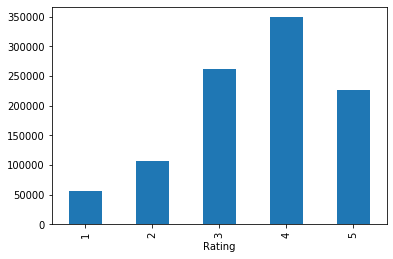

In [2]:
#define paths
input_folder = r'C:\Users\Liam\Documents\atziProj\267_wankers\ml-1m'
data_path = os.path.join(input_folder, 'ratings.dat')
movie_path = os.path.join(input_folder, 'movies.dat')

#read ratings data
data = pd.read_csv(data_path, sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
data = data.drop(columns='Timestamp')
data.head()

# Extract the ratings from the DataFrame
ratings = data['Rating']

# Plot histogram
data.groupby('Rating').size().plot(kind='bar');
data['Rating'].describe()

#find unquie users/movies
num_users = data['UserID'].unique().shape[0]
num_items = data['MovieID'].unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


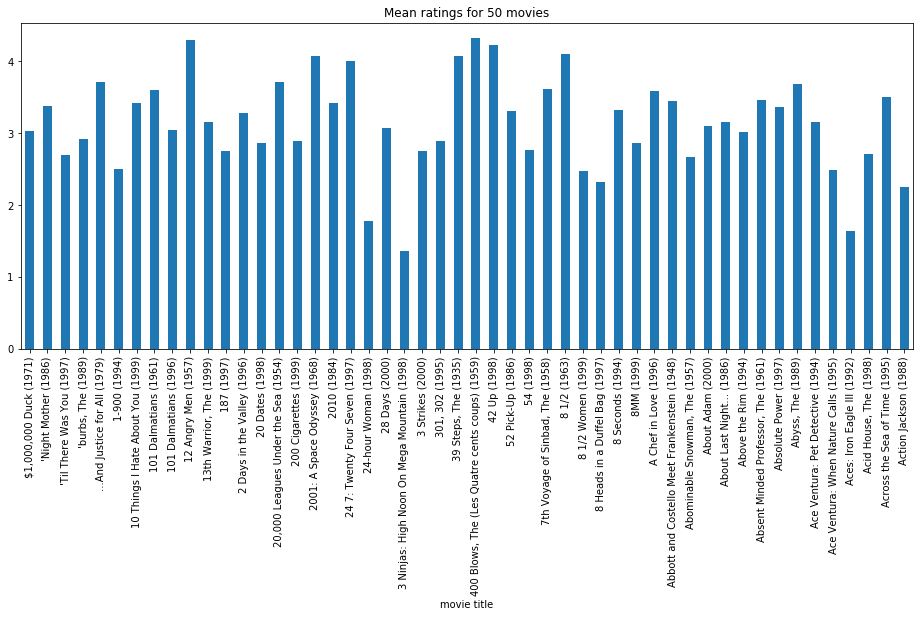

In [3]:
#read movie data
movie_columns  = ['movie id', 'movie title',
                  'genre']
movies = pd.read_csv(movie_path, sep="::", names=movie_columns, index_col="movie id")
movies.head()
movie_means = data.join(movies['movie title'], on='MovieID').groupby('movie title')['Rating'].mean()
movie_means[:50].plot(kind='bar', grid=False, figsize=(16, 6),
                      title="Mean ratings for 50 movies");


# Define PMF model

In [4]:
# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF():
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=(U @ V.T)[~nan_mask], tau=self.alpha,
                observed=self.data[~nan_mask])

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name


def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using L-BFGS-B optimization...')
        self._map = pm.find_MAP(method='L-BFGS-B')

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)
    return self._map

def _map(self):
    try:
        return self._map
    except:
        return self.find_map()     

def _draw_samples(self, **kwargs):
    kwargs.setdefault('chains', 1)
    with self.model:
        self.trace = pm.sample(**kwargs)

def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R

def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ('U', 'V')
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")
    
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R, results






# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples
PMF.predict = _predict
PMF.norms = _norms
PMF.find_map = _find_map
PMF.map = property(_map)
PMF.norms = _norms
PMF.traceplot = _traceplot
PMF.running_rmse = _running_rmse



# Evaluation and data splitting helper functions

In [5]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE

# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # movies
    N = n * m                     # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size   # and remainder for training

    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(train_size == N-np.isnan(train).sum())
    assert(test_size == N-np.isnan(test).sum())

    # Return train set and test set
    return train, test

def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print('PMF MAP training RMSE: %.5f' % train_rmse)
    print('PMF MAP testing RMSE:  %.5f' % test_rmse)
    print('Train/test difference: %.5f' % overfit)

    return test_rmse

# Build model

In [6]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(9764), so for 10
# dimensions, we are sampling 97640 latent variables.
DIM = 10

dense_data = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').values
train, test = split_train_test(dense_data)
pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
INFO:root:done building the PMF model


# Train Model

In [ ]:
# Find MAP for PMF.
pmf.find_map();

INFO:root:finding PMF MAP using L-BFGS-B optimization...
logp = -1.2885e+07, ||grad|| = 1.0455e+05:   0%|                                  | 15/5000 [04:37<25:42:48, 18.57s/it]

# MCMC sampling to estimate prior distrobution

In [ ]:
# Draw MCMC samples.
pmf.draw_samples(draws=500, tune=500, )
predicted, results = pmf.running_rmse(test, train)


# Evaluate results

In [ ]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)

final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print('Posterior predictive train RMSE: %.5f' % final_train_rmse)
print('Posterior predictive test RMSE:  %.5f' % final_test_rmse)
print('Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse))
print('Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse))